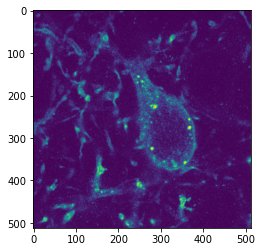

In [25]:
from PIL import Image
import numpy as np
from tifffile import imsave
import math
import matplotlib.pyplot as plt
import torch
CURVATURE_INCREMENT = 3
CURVATURE_ITERATION = 3
FRAME_SIZE = 40
HALF_SIZE = int(FRAME_SIZE/2)
DECAY_RATE = 1
WIDTH = 4
%matplotlib inline
Second_Layer_Kernel_Size = 151
CURVATURE = 10
    

def save_image_as_tiff(image,filename):
	image = np.einsum('ijk->kij', image)
	image = np.flip(image, axis=(1, 2))
	imsave(filename,image)

def Distance2Line(i, j, a, b, c):
    return abs(a * i + b * j + c) / math.sqrt(a**2 + b**2)

class LayerGeneration:
    def GenerateTopLayerWeights(angle, curvature):
        weight = np.zeros([FRAME_SIZE,FRAME_SIZE])
        a = math.cos(angle)
        b = math.sin(angle)
        c = -HALF_SIZE * (a + b)
        if curvature == 0:
            for i in range(FRAME_SIZE):
                for j in range(FRAME_SIZE):
                    dist = Distance2Line(i, j, a, b, c)
                    if dist < WIDTH:
                        weight[i,j] = 1
                    elif dist < DECAY_RATE:
                        weight[i,j] = 1 - (dist-WIDTH) / DECAY_RATE
                    else:
                        weight[i,j] = 0 
        elif curvature > 0:
            r = (curvature * curvature + HALF_SIZE * HALF_SIZE) / (2 * curvature)
            x0 = (r * math.sqrt(a * a + b * b) + HALF_SIZE * b * b / a - HALF_SIZE * b - c) / (a + b * b / a)
            y0 = HALF_SIZE + (x0 - HALF_SIZE) * b / a
            for i in range(FRAME_SIZE):
                for j in range(FRAME_SIZE):
                    dist = math.sqrt((i - x0)**2 + (j - y0)**2)
                    if (dist > r - WIDTH) and (dist < r + WIDTH):
                        weight[i,j] = 1
                    elif (dist > r - DECAY_RATE) and (dist < r + DECAY_RATE):
                        weight[i,j] =  1 - (np.abs(r - dist)-WIDTH) / DECAY_RATE
                    else:
                        weight[i,j] = 0    
        return weight - np.mean(weight)
   
    
    def GenerateSecondLayerWeights(radius):
        L = np.arange(-(Second_Layer_Kernel_Size-1)/2, (Second_Layer_Kernel_Size-1)/2 + 1)
        L0 = np.arange(int(-Second_Layer_Kernel_Size/4), int(Second_Layer_Kernel_Size/4 + 1))
        Z, X, Y = np.meshgrid(L0, L, L)
        weight = X ** 2 + Y ** 2 + 4*(Z ** 2)
        weight = np.logical_and(weight <= radius ** 2, weight >= (radius-DECAY_RATE)**2).astype(float)
        return np.einsum('kij->ijk', weight*255)-np.mean(weight)
    
    
    def GenerateThirdLayerWeights(radius):
        L = np.arange(-radius, radius + 1)
        L0 = np.arange(int(-radius/2), int(radius/2 + 1))
        Z, X, Y = np.meshgrid(L0, L, L)
        weight = X ** 2 + Y ** 2 + 4*(Z ** 2)
        weight = np.logical_and(weight <= radius ** 2, weight >= (radius-DECAY_RATE)**2).astype(float)
        return np.einsum('kij->ijk', weight*255)-np.mean(weight)


def ReadDataFromTif(nframes, h, w):
    img_r = np.zeros((h, w, nframes))
    img_g = np.zeros((h, w, nframes))
    img_b = np.zeros((h, w, nframes))
    img_a = np.zeros((h, w, nframes))
    for i in range(nframes):
        img.seek(i*4)
        img_r[:, :, i] = np.array(img)
        img.seek(i * 4 + 1)
        img_g[:, :, i] = np.array(img)
        img.seek(i * 4 + 2)
        img_b[:, :, i] = np.array(img)
        img.seek(i * 4 + 3)
        img_a[:, :, i] = np.array(img)
    img_rgba = np.max(np.stack([img_r, img_g, img_b, img_a]), axis=0)
    return img_rgba
        
def Read1FrameFromTif(nframes, h, w):
    img.seek(nframes * 4 + 1)
    img_r = np.array(img)
    img.seek(nframes * 4 + 2)
    img_g = np.array(img)
    img.seek(nframes * 4 + 3)
    img_b = np.array(img)
    img.seek(nframes * 4 + 4)
    img_a = np.array(img)
    img_rgba = np.max(np.stack([img_r, img_g, img_b, img_a]), axis=0)
    return img_rgba

def Layer1TorchConv(image,pattern,normalization):
    #image = np.einsum('ijk->kij', image)
    torch.cuda.empty_cache()
    pattern_tensor = torch.zeros(pattern.shape[0], 1, FRAME_SIZE, FRAME_SIZE, FRAME_SIZE)
    pattern_tensor[:,0,:,:,:] = torch.from_numpy(pattern)
    image_tensor = torch.zeros(1,1,h,w,n_frames)
    image_tensor[0,0,:,:,:] = torch.from_numpy(image)
    sigmoid_f = torch.nn.Sigmoid()
    image_tensor = (sigmoid_f(image_tensor*2)-0.5)*0.5
    layer1 = torch.nn.Conv3d(1, pattern_tensor.size(dim=0), (FRAME_SIZE, FRAME_SIZE, FRAME_SIZE))
    layer1.load_state_dict({'weight': pattern_tensor}, strict=False)
    image_tensor=torch.nn.functional.pad(image_tensor, tuple((HALF_SIZE, HALF_SIZE, HALF_SIZE, HALF_SIZE, HALF_SIZE, HALF_SIZE)))
    out_layer1=layer1(image_tensor)
    if(normalization==True):
        pooling=torch.nn.AvgPool2d(FRAME_SIZE,stride=1)
        normalization_map = pooling(image_tensor)
        #print(normalization_map.size(),out_layer1.size())
        for kernal_frame in range(out_layer1.size()[1]):
            out_layer1[:,kernal_frame,:,:] = out_layer1[:,kernal_frame,:,:] - normalization_map * torch.sum(pattern_tensor[kernal_frame,:,:,:])
    out_layer1=torch.max(out_layer1,1).values    
    return out_layer1.detach().numpy()

img = Image.open('C:/Users/brian/Documents/nTracer sample.tif')
h, w = np.shape(img)
nframes = int(img.n_frames/4)
image=Read1FrameFromTif(72,h,w)
image=image-np.min(image)-(np.max(image)-np.min(image))/2
fig=plt.figure()
plt.imshow(image)

In [26]:
#pytorch convolution algorithm
image=ReadDataFromTif(nframes,h,w)
image=image-np.min(image)
image=image/np.max(image)
norm_offset=np.mean(image)
image=image-norm_offset
print(np.max(image),np.min(image))

Layer1out = np.zeros((3,image.shape[0]+1,image.shape[1]+1,image.shape[2]+1))

pattern = np.load('np arrays/line_Pattern')
Layer1out[1,:,:,:] = Layer1TorchConv(image,pattern - norm_offset, False)

pattern = np.zeros(HALF_SIZE, HALF_SIZE, HALF_SIZE)
Layer1out[0,:,:,:] = Layer1TorchConv(image,pattern - norm_offset, False)

for R in range(50,101,10):
    pattern = np.load('np arrays/Membrane_Pattern_'+str(R))
    Layer1out[2,:,:,:] = np.maximum(Layer1TorchConv(image,pattern - norm_offset, False), Layer1out[2,:,:,:])

0.9307008403049115 -0.06929915969508844


In [28]:
for i in range(3):
    Layer1out[i,:,:,:]=Layer1out[i,:,:,:]-np.min(Layer1out[i,:,:,:])
    Layer1out[i,:,:,:]=Layer1out[i,:,:,:]/np.max(Layer1out[i,:,:,:])
Layer1out[2,:,:,:]=Layer1out[:,2,:,:]*0.5
Layer1out[0,:,:,:]=Layer1out[:,0,:,:]*0.9

33.097537994384766 -7.495479106903076
133.2566680908203 -21.20356559753418
1.6039962768554688 -9.89684772491455


In [ ]:
Layer1out[0,:,:,:] = Layer1out[0,:,:,:] * (np.max(image) - image)
Layer1out[1,:,:,:] = Layer1out[1,:,:,:] * (image + norm_offset)
Layer1out[2,:,:,:] = Layer1out[2,:,:,:] * (image + norm_offset)

In [29]:
Layer1out_max_index = np.argmax(Layer1out,axis=1)
Layer1out_mask = np.zeros(Layer1out.shape)
for i in range(3):
    Layer1out_mask[i,:,:,:]=(Layer1out_max_index==i)
Layer1out_mask = np.einsum('ijkl->lijk', Layer1out_mask)
imsave('C:/Users/brian/Documents/Layer1_Segmentation_Mask.tif',Layer1out_mask.astype(float))
imsave('C:/Users/brian/Documents/Layer1_Segmentation.tif',np.einsum('ijkl->lijk', Layer1out))

In [47]:
Layer1outmask=Layer1out[:,0,:,:]
print(np.min(Layer1outmask),np.max(Layer1outmask))
Layer1outmask=Layer1outmask-np.min(Layer1outmask)-(np.max(Layer1outmask)-np.min(Layer1outmask))*1/10
Layer1outmask[Layer1outmask<0]=0

#Layer1outmask = np.flip(Layer1outmask, axis=(1, 2))
imsave('C:/Users/v-brianma/Neuron Reconstruction/Layer1ConvOut.tif',Layer1outmask)

0.0 220.7521209716797


(210, 663, 663)
0.0 198.67690887451172


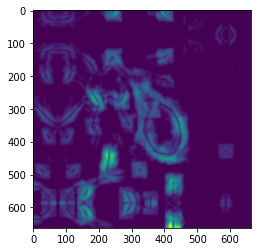

In [51]:
print(Layer1outmask.shape)
print(np.min(Layer1outmask),np.max(Layer1outmask))
plt.imshow(Layer1outmask[110,:,:])

In [ ]:
pattern2=LayerGeneration.GenerateSecondLayerWeights(70)
print(pattern2.shape,Layer1out[:,0,:,:].shape)


(75, 151, 151) (210, 663, 663)


In [ ]:
Layer2out_map = Layer2torchConv(Layer1outmask-np.mean(Layer1outmask),pattern2)

(210, 663, 663)
start layer2
end layer2


In [ ]:
Layer2out_mask=Layer2out_map[0,0,:,:,:]
Layer2out_mask=Layer2out_mask-np.min(Layer2out_mask)-(np.max(Layer2out_mask)-np.min(Layer2out_mask))*1/2
Layer2out_mask=250*Layer2out_mask/np.max(Layer2out_mask)
Layer2out_mask=-Layer2out_mask.astype(int)
Layer2out_mask[Layer2out_mask<0]=0
imsave('C:/Users/brian/Documents/Layer2ConvOut.tif',Layer2out_mask)

In [ ]:
pattern3=LayerGeneration.GenerateThirdLayerWeights(70)
Layer3out_map = Layer3torchConv(Layer2out_map-np.mean(Layer2out_map),pattern3,141)

layer13 start
layer3 end


In [ ]:
Layer3out_mask = Layer3out_map[0,0,:,:,:]
Layer3out_mask=Layer3out_mask-np.min(Layer3out_mask)-(np.max(Layer3out_mask)-np.min(Layer3out_mask))*1/2
Layer3out_mask=250*Layer3out_mask/np.max(Layer3out_mask)
Layer3out_mask=-Layer3out_mask.astype(int)
Layer3out_mask[Layer3out_mask<0]=0
imsave('C:/Users/brian/Documents/Layer3ConvOut.tif',Layer3out_mask)